In [1]:
from demo_driver import *

In [1]:
from config import CFG
try:
    out
except NameError:
    from simulate import run
    out = run(progress=True)

T_sec = sum(seg["T_ms"] for seg in out["schedule"]) / 1000.0
E_spikes = out["E_spike_times"]; I_spikes = out["I_spike_times"]

mean_e_rate = sum(len(s) for s in E_spikes) / (CFG.N_E * T_sec)
mean_i_rate = sum(len(s) for s in I_spikes) / (CFG.N_I * T_sec)
print(f"Mean E rate: {mean_e_rate:.2f} Hz, Mean I rate: {mean_i_rate:.2f} Hz")

import numpy as np
for name, W in out["weights"].items():
    print(name, "finite:", np.isfinite(W).all())


Simulating:   0%|          | 0/22759 [00:00<?, ?ms/s]

Mean E rate: 70.13 Hz, Mean I rate: 96.80 Hz
W_inpE finite: True
W_EE finite: True


In [6]:
# Dial down drive (safe, paper-compatible knobs)
from config import CFG
CFG.gamma_exc = 0.6      # generic excitatory offset: E_exc,generic = gamma_exc * 300
CFG.gamma_w   = 0.30     # scales Inp→E and E→E initial means

# (optionally) run the full protocol for best assemblies
# CFG.FAST_DEMO = False

# Re-run
from simulate import run
out = run(progress=True)

# Quick rate check by phase (optional)
sched = out["schedule"]
T = sum(s["T_ms"] for s in sched)
phase_tags = []
t = 0
for s in sched:
    label = ("noise0" if t==0 else
             "encoding" if s["kind"]=="pattern" else
             "association" if s["kind"]=="combined" else
             "noise")
    phase_tags.append((t, t+s["T_ms"], label))
    t += s["T_ms"]

def mean_rate(spikes, t0, t1):
    n = sum((t0 <= ts).sum() - (t1 <= ts).sum() for ts in spikes)  # integer arithmetic
    return n / ((len(spikes) * (t1 - t0)) / 1000)

print("Mean E Hz:", mean_rate(out["E_spike_times"], 0, T))
print("Mean I Hz:", mean_rate(out["I_spike_times"], 0, T))


Simulating:   0%|          | 0/22708 [00:00<?, ?ms/s]

Mean E Hz: 0.0
Mean I Hz: 99.19737863634288


In [10]:
# --- Parameter sweep for gamma_w and gamma_exc (short FAST_DEMO runs) ---
import numpy as np, pandas as pd, math
from copy import deepcopy

from config import CFG
from simulate import run
from analyze import detect_PRUs

# Candidates (edit as needed)
gamma_w_list   = [0.25, 0.35, 0.50]
gamma_exc_list = [0.50, 0.70, 0.90]
DEMO_SCALE_FOR_SWEEP = 0.01  # 1% of full durations

# Helpers
def enc_bounds(schedule):
    t_enc_start = schedule[0]["T_ms"]
    acc, t_enc_end = 0, sum(s["T_ms"] for s in schedule)
    for seg in schedule:
        if seg["kind"] == "combined":
            t_enc_end = acc; break
        acc += seg["T_ms"]
    return t_enc_start, t_enc_end

def assoc_bounds(schedule):
    starts, ends, acc = [], [], 0
    for seg in schedule:
        if seg["kind"] == "combined":
            starts.append(acc); ends.append(acc + seg["T_ms"])
        acc += seg["T_ms"]
    return (starts[0], ends[-1]) if starts else (None, None)

def onsets_between(schedule, labels, t0, t1):
    d = {lab: [] for lab in labels}
    acc = 0
    for seg in schedule:
        if seg["kind"]=="pattern" and seg["label"] in labels and (t0 <= acc < t1):
            d[seg["label"]].append(acc)
        acc += seg["T_ms"]
    for k in d: d[k] = np.array(d[k], dtype=int)
    return d

def mean_rate(spike_trains, t0, t1):
    total = 0
    for ts in spike_trains:
        if len(ts): total += np.sum((ts >= t0) & (ts < t1))
    dur_s = (t1 - t0) / 1000.0
    return total / (len(spike_trains) * dur_s) if dur_s > 0 else float('nan')

def pair_mean(W, A, B):
    if A.size==0 or B.size==0: return float("nan")
    return float(W[np.ix_(A, B)].mean())

def cross_assoc_delta(out, assemblies, a0, a1):
    snap = out["snapshots"]
    if a0 not in snap or a1 not in snap: return float("nan")
    W_pre, W_post = snap[a0][1], snap[a1][1]  # E→E
    blue  = np.array(assemblies["blue"],  int)
    green = np.array(assemblies["green"], int)
    pre_BG,  post_BG  = pair_mean(W_pre,  blue, green), pair_mean(W_post, blue, green)
    pre_GB,  post_GB  = pair_mean(W_pre,  green, blue), pair_mean(W_post, green, blue)
    if any(map(lambda x: isinstance(x, float) and (np.isnan(x) or np.isinf(x)),
               [pre_BG, post_BG, pre_GB, post_GB])):
        return float("nan")
    return (post_BG - pre_BG) + (post_GB - pre_GB)

def score_row(e_hz, i_hz, nB, nG):
    # Aim E≈5 Hz; discourage very high I; reward blue/green PRUs
    se = (e_hz - 5.0)**2
    pi = 0.25 * max(0.0, i_hz - 80.0)**2
    reward = 0.5 * (nB + nG)
    return se + pi - reward

# Sweep
orig = deepcopy(CFG.__dict__)
rows = []
for gw in gamma_w_list:
    for gexc in gamma_exc_list:
        CFG.gamma_w   = gw
        CFG.gamma_exc = gexc
        CFG.FAST_DEMO = True
        CFG.demo_scale = DEMO_SCALE_FOR_SWEEP

        out = run(progress=False)

        enc0, enc1 = enc_bounds(out["schedule"])
        labels = ["blue","green","red"]
        enc_on = onsets_between(out["schedule"], labels, enc0, enc1)

        e_hz = mean_rate(out["E_spike_times"], enc0, enc1)
        i_hz = mean_rate(out["I_spike_times"], enc0, enc1)

        res = detect_PRUs(out["E_spike_times"], enc_on, labels)
        assemblies = res["assemblies"]
        nB, nG, nR = len(assemblies["blue"]), len(assemblies["green"]), len(assemblies["red"])

        a0, a1 = assoc_bounds(out["schedule"])
        delta = cross_assoc_delta(out, assemblies, a0, a1) if a0 is not None else float("nan")

        rows.append(dict(gamma_w=gw, gamma_exc=gexc,
                         E_Hz_enc=e_hz, I_Hz_enc=i_hz,
                         PRU_blue=nB, PRU_green=nG, PRU_red=nR,
                         cross_BG_GB_delta=delta,
                         score=score_row(e_hz, i_hz, nB, nG)))

# Restore config
for k,v in orig.items(): setattr(CFG, k, v)

df = pd.DataFrame(rows).sort_values("score").reset_index(drop=True)
best = df.iloc[0]
print(f"Suggested: gamma_w={best.gamma_w:.2f}, gamma_exc={best.gamma_exc:.2f} "
      f"(E~{best.E_Hz_enc:.2f} Hz, I~{best.I_Hz_enc:.2f} Hz, PRUs B/G={int(best.PRU_blue)}/{int(best.PRU_green)})")

display(df)
df.to_csv("gamma_sweep_results.csv", index=False)
print("Saved: gamma_sweep_results.csv")


Suggested: gamma_w=0.25, gamma_exc=0.90 (E~0.00 Hz, I~87.85 Hz, PRUs B/G=0/0)


,gamma_w,gamma_exc,E_Hz_enc,I_Hz_enc,PRU_blue,PRU_green,PRU_red,cross_BG_GB_delta,score
0,0.25,0.9,0.000000,87.854471,0,0,0,NaN,40.423177
1,0.50,0.7,0.000000,88.439223,0,0,0,NaN,42.805123
2,0.35,0.9,0.000000,90.689752,0,0,0,NaN,53.567699
3,0.25,0.7,0.000000,93.993774,0,0,0,NaN,73.956429
4,0.50,0.5,0.000000,94.381777,0,0,0,NaN,76.708875
5,0.35,0.7,0.000000,103.185230,0,0,0,NaN,159.388720
6,0.35,0.5,0.000000,103.355922,0,0,0,NaN,161.374777
7,0.25,0.5,0.000000,106.418780,0,0,0,NaN,199.487982
8,0.50,0.9,65.990748,108.767581,0,8,6,NaN,3922.764791


Saved: gamma_sweep_results.csv


In [1]:
# === Adaptive tuning for (gamma_w, gamma_exc) with tiny schedules + progress bar ===
# Fix: custom schedules now include the required 'on' field for pattern/combined segments.

import numpy as np, math
from copy import deepcopy
try:
    from tqdm.auto import tqdm
except Exception:
    class tqdm:
        def __init__(self, total=None, desc=None): self.n=0; self.total=total
        def update(self, n=1): self.n += n
        def close(self): pass
        def __enter__(self): return self
        def __exit__(self, *a): pass

from config import CFG
import simulate as sim
from analyze import detect_PRUs

# ---------------- helpers ----------------
def _mean_rate(spike_trains, t0, t1):
    tot=0
    for ts in spike_trains:
        if len(ts): tot += np.sum((ts>=t0)&(ts<t1))
    dur=(t1-t0)/1000.0
    return tot/(len(spike_trains)*dur) if dur>0 else float('nan')

def _enc_bounds(sched):
    enc0 = sched[0]["T_ms"]
    acc = 0
    enc1 = sum(s["T_ms"] for s in sched)
    for seg in sched:
        if seg["kind"]=="combined":
            enc1 = acc
            break
        acc += seg["T_ms"]
    return enc0, enc1

def _onsets_between(sched, labels, t0, t1):
    d={k:[] for k in labels}; acc=0
    for seg in sched:
        if seg["kind"]=="pattern" and seg["label"] in labels and (t0 <= acc < t1):
            d[seg["label"]].append(acc)
        acc += seg["T_ms"]
    for k in d: d[k]=np.array(d[k],int)
    return d

# --------- tiny schedules (ms) ---------
def _schedule_noise_only(T_ms=3000):
    return [dict(kind="noise", T_ms=int(T_ms), label=None, on=None)]

def _schedule_tiny_encoding(n_trials=12, gap_ms=300, noise_lead_ms=500):
    labels = ["blue","green","red"]
    rng = np.random.default_rng(0)
    order = rng.choice(labels, size=n_trials, replace=True)
    sched = [dict(kind="noise", T_ms=int(noise_lead_ms), label=None, on=None)]
    for lab in order:
        sched.append(dict(kind="pattern", label=lab, T_ms=100))         # 'on' added in _run_with_schedule
        sched.append(dict(kind="noise", label=None, T_ms=int(gap_ms), on=None))
    return sched

def _run_with_schedule(custom_schedule):
    """Patch build_schedule to return 'custom_schedule' and attach 'on' arrays from 'patterns'."""
    orig_build = sim.build_schedule
    def _one_shot_schedule(patterns):
        # Build a per-label 'on' map; also provide 'combined' = union(blue, green)
        on_map = {
            "blue": np.array(patterns["blue"], dtype=int),
            "green": np.array(patterns["green"], dtype=int),
            "red": np.array(patterns["red"], dtype=int),
        }
        on_map["combined"] = np.unique(np.concatenate([on_map["blue"], on_map["green"]]))
        # Attach 'on' to pattern/combined segments; keep noise 'on=None'
        sched = []
        for seg in custom_schedule:
            seg = dict(seg)  # shallow copy
            if seg["kind"] in ("pattern", "combined"):
                lab = seg.get("label", "combined")
                seg["on"] = on_map[lab]
            else:
                seg["on"] = None
            sched.append(seg)
        return sched
    sim.build_schedule = _one_shot_schedule
    try:
        out = sim.run(progress=False)
    finally:
        sim.build_schedule = orig_build
    return out

# -------------- A) calibrate gamma_exc on noise-only --------------
def calibrate_gamma_exc(target_E_hz=3.0, tol=1.0, max_iter=7, noise_ms=3000, hold_gamma_w=0.35):
    ori = deepcopy(CFG.__dict__)
    try:
        CFG.gamma_w = hold_gamma_w
        low, high = 0.65, 1.05
        best = None
        with tqdm(total=max_iter, desc="Calibrating gamma_exc (noise)") as pbar:
            for _ in range(max_iter):
                mid = 0.5*(low+high)
                CFG.gamma_exc = mid
                out = _run_with_schedule(_schedule_noise_only(T_ms=noise_ms))
                E_hz = _mean_rate(out["E_spike_times"], 0, noise_ms)
                if not np.isfinite(E_hz): E_hz = np.nan
                err = E_hz - target_E_hz
                best = (mid, E_hz, err)
                if np.isnan(E_hz) or err < -tol:
                    low = mid
                elif err > tol:
                    high = mid
                else:
                    break
                pbar.update(1)
    finally:
        for k,v in ori.items(): setattr(CFG, k, v)
    return dict(gamma_exc=best[0], E_hz_noise=best[1], err=best[2])

# -------------- B) calibrate gamma_w on tiny encoding --------------
def calibrate_gamma_w(gamma_exc_fixed, target_E_hz=6.0, tol=2.0,
                      max_iter=8, n_trials=15, gap_ms=300):
    ori = deepcopy(CFG.__dict__)
    try:
        CFG.gamma_exc = gamma_exc_fixed
        low, high = 0.25, 0.60
        best = None
        with tqdm(total=max_iter, desc="Calibrating gamma_w (tiny encoding)") as pbar:
            for _ in range(max_iter):
                mid = 0.5*(low+high)
                CFG.gamma_w = mid
                out = _run_with_schedule(_schedule_tiny_encoding(n_trials=n_trials, gap_ms=gap_ms))
                enc0, enc1 = _enc_bounds(out["schedule"])
                E_hz = _mean_rate(out["E_spike_times"], enc0, enc1)
                if not np.isfinite(E_hz): E_hz = np.nan
                err = E_hz - target_E_hz
                enc_on = _onsets_between(out["schedule"], ["blue","green","red"], enc0, enc1)
                prus = detect_PRUs(out["E_spike_times"], enc_on, ["blue","green","red"])["assemblies"]
                nB, nG = len(prus["blue"]), len(prus["green"])
                best = (mid, E_hz, err, nB, nG)
                if np.isnan(E_hz) or err < -tol:
                    low = mid
                elif err > tol:
                    high = mid
                else:
                    if (nB + nG) >= 2:
                        break
                    else:
                        low = mid
                pbar.update(1)
    finally:
        for k,v in ori.items(): setattr(CFG, k, v)
    return dict(gamma_w=best[0], E_hz_enc=best[1], err=best[2], PRU_blue=best[3], PRU_green=best[4])

# ----------------- Run both steps -----------------
res_exc = calibrate_gamma_exc(target_E_hz=3.0, tol=1.0, max_iter=7, noise_ms=2500)
res_w   = calibrate_gamma_w(res_exc["gamma_exc"], target_E_hz=6.0, tol=2.0,
                            max_iter=8, n_trials=15, gap_ms=300)

print("\n--- Suggested parameters ---")
print(f"gamma_exc ≈ {res_exc['gamma_exc']:.3f} (E~{res_exc['E_hz_noise']:.2f} Hz during noise-only)")
print(f"gamma_w   ≈ {res_w['gamma_w']:.3f} (E~{res_w['E_hz_enc']:.2f} Hz during tiny encoding; "
      f"PRUs B/G={res_w['PRU_blue']}/{res_w['PRU_green']})")

# Optional: apply immediately
APPLY_TO_CFG = False
if APPLY_TO_CFG:
    CFG.gamma_exc = float(res_exc['gamma_exc'])
    CFG.gamma_w   = float(res_w['gamma_w'])
    print("\nApplied to CFG. You can now run:  out = sim.run(progress=True)")
else:
    print("\nSet these in CFG and run a normal (FAST_DEMO or full) simulation.")


Calibrating gamma_exc (noise):   0%|          | 0/7 [00:00<?, ?it/s]

Calibrating gamma_w (tiny encoding):   0%|          | 0/8 [00:00<?, ?it/s]


--- Suggested parameters ---
gamma_exc ≈ 1.047 (E~0.00 Hz during noise-only)
gamma_w   ≈ 0.396 (E~68.51 Hz during tiny encoding; PRUs B/G=11/10)

Set these in CFG and run a normal (FAST_DEMO or full) simulation.


In [1]:
from importlib import reload
import config, simulate
reload(config); reload(simulate)

print("same object?", config.CFG is simulate.CFG)  # must be True


same object? True


In [3]:
from importlib import reload
import config, simulate
reload(config); reload(simulate)

# set params ON THE SAME OBJECT simulate.CFG
simulate.CFG.gamma_w   = 0.36
simulate.CFG.gamma_exc = 1.00
simulate.CFG.FAST_DEMO = True
simulate.CFG.demo_scale= 0.02

# (A) baseline
simulate.CFG.scale_IE  = 1.00
simulate.CFG.scale_II  = 1.00
out = simulate.run(progress=False)
def mean_rate(spikes, T_ms):
    return sum(len(s) for s in spikes)/(len(spikes)*(T_ms/1000))
T_ms = sum(s["T_ms"] for s in out["schedule"])
E0 = mean_rate(out["E_spike_times"], T_ms)
I0 = mean_rate(out["I_spike_times"], T_ms)
print("baseline E/I:", E0, I0)

# (B) kill I→I (should INCREASE I rate or destabilize; test effect)
simulate.CFG.scale_II = 0.0
out = simulate.run(progress=False)
T_ms = sum(s["T_ms"] for s in out["schedule"])
E1 = mean_rate(out["E_spike_times"], T_ms)
I1 = mean_rate(out["I_spike_times"], T_ms)
print("scale_II=0.0 E/I:", E1, I1)

# (C) very strong I→I (should DECREASE I rate vs baseline)
simulate.CFG.scale_II = 5.0
out = simulate.run(progress=False)
T_ms = sum(s["T_ms"] for s in out["schedule"])
E2 = mean_rate(out["E_spike_times"], T_ms)
I2 = mean_rate(out["I_spike_times"], T_ms)
print("scale_II=5.0 E/I:", E2, I2)


KeyboardInterrupt: 

In [3]:

from config import CFG
import simulate as sim
from importlib import reload
from analyze import detect_PRUs
import simulate
from importlib import reload
import config, simulate
reload(config); reload(simulate)   # picks up any file edits


simulate.CFG.gamma_w   = 0.36
simulate.CFG.gamma_exc = 1.00
simulate.CFG.scale_IE  = 1.00   # keep in ~0.9–1.1 range
simulate.CFG.scale_II  = 100   # DO NOT use 100; ~0.95–1.15 only
simulate.CFG.FAST_DEMO = True
simulate.CFG.demo_scale= 0.02

from importlib import reload
import config, simulate
reload(config); reload(simulate)

print("Same CFG object?", config.CFG is simulate.CFG)  # MUST be True
print("IDs:", id(config.CFG), id(simulate.CFG))


# out = run(progress=True)


# T_sec = sum(seg["T_ms"] for seg in out["schedule"]) / 1000.0
# E_spikes = out["E_spike_times"]; I_spikes = out["I_spike_times"]

# mean_e_rate = sum(len(s) for s in E_spikes) / (CFG.N_E * T_sec)
# mean_i_rate = sum(len(s) for s in I_spikes) / (CFG.N_I * T_sec)
# print(f"Mean E rate: {mean_e_rate:.2f} Hz, Mean I rate: {mean_i_rate:.2f} Hz")

# import numpy as np
# for name, W in out["weights"].items():
#     print(name, "finite:", np.isfinite(W).all())



Same CFG object? True
IDs: 2379474729088 2379474729088


In [1]:
from importlib import reload
import config, simulate
reload(config); reload(simulate)

def quick_run(scale_II):
    simulate.CFG.gamma_w   = 0.36
    simulate.CFG.gamma_exc = 1.00
    simulate.CFG.scale_IE  = 1.00
    simulate.CFG.scale_II  = scale_II
    simulate.CFG.FAST_DEMO = True
    simulate.CFG.demo_scale= 0.01

    out = simulate.run(progress=True)
    T_ms = sum(s["T_ms"] for s in out["schedule"])
    E = sum(len(s) for s in out["E_spike_times"]) / (simulate.CFG.N_E * (T_ms/1000))
    I = sum(len(s) for s in out["I_spike_times"]) / (simulate.CFG.N_I * (T_ms/1000))
    return E, I

for sII in [0.0, 1.0, 10.0]:
    E,I = quick_run(sII)
    print(f"scale_II={sII:>4}:  E={E:6.2f} Hz   I={I:6.2f} Hz")


Simulating:   0%|          | 0/12317 [00:00<?, ?ms/s]

scale_II= 0.0:  E= 61.78 Hz   I=328.79 Hz


Simulating:   0%|          | 0/12341 [00:00<?, ?ms/s]

scale_II= 1.0:  E= 69.47 Hz   I= 98.27 Hz


Simulating:   0%|          | 0/12258 [00:00<?, ?ms/s]

scale_II=10.0:  E= 69.87 Hz   I=114.31 Hz


In [3]:
# --- A/B verifier: do CFG knobs actually change the built network? ---
# Compares:
#  • demo_scale → total schedule ms (should scale linearly)
#  • gamma_w    → mean(W_inpE) & mean(W_EE) (should scale ∝ gamma_w)
#  • scale_II   → mean(W_II) (should scale ∝ scale_II)
#  • scale_IE   → mean(W_IE) (should scale ∝ scale_IE)
#
# Usage: paste and run in a fresh kernel. Read the "EXPECTED vs OBSERVED" prints.

from importlib import reload
import numpy as np
import config, simulate

# Fresh reload so both modules share the same CFG object
reload(config); reload(simulate)
print("Same CFG object?", config.CFG is simulate.CFG, "  IDs:", id(config.CFG), id(simulate.CFG))

def _run_once(overrides: dict):
    """Set overrides on simulate.CFG, run a tiny sim, return total ms and weight means."""
    # Save/restore CFG cleanly
    saved = simulate.CFG.__dict__.copy()
    try:
        # Apply overrides
        for k, v in overrides.items():
            setattr(simulate.CFG, k, v)
        # Defaults for a quick, comparable run
        simulate.CFG.FAST_DEMO = True if "FAST_DEMO" not in overrides else simulate.CFG.FAST_DEMO
        simulate.CFG.demo_scale = 0.002 if "demo_scale" not in overrides else simulate.CFG.demo_scale
        # Fix seed so sampling is identical except for the knob we change
        if hasattr(simulate.CFG, "seed"):
            simulate.CFG.seed = 12345

        out = simulate.run(progress=True)

        T_ms = sum(seg["T_ms"] for seg in out["schedule"])
        W = out["weights"]  # dict with W_inpE, W_EE, W_IE, W_II
        means = {name: (float(np.mean(M)) if (M is not None) else np.nan)
                 for name, M in W.items()}
        return T_ms, means
    finally:
        # Restore CFG
        for k, v in saved.items():
            setattr(simulate.CFG, k, v)

def _fmt(means): return ", ".join(f"{k}={v:.3f}" for k, v in means.items())

# ----- Baseline A -----
A_T, A_means = _run_once(dict(gamma_w=0.36, gamma_exc=1.00, scale_IE=1.00, scale_II=1.00,
                              FAST_DEMO=True, demo_scale=0.002))

# ----- Variant: demo_scale x10 (expect ~10x total ms) -----
Bdemo_T, Bdemo_means = _run_once(dict(gamma_w=0.36, gamma_exc=1.00, scale_IE=1.00, scale_II=1.00,
                                      FAST_DEMO=True, demo_scale=0.020))

# ----- Variant: gamma_w ↑ (expect W_inpE & W_EE scale by 0.50/0.36 ≈ 1.39) -----
Bgw_T, Bgw_means = _run_once(dict(gamma_w=0.50, gamma_exc=1.00, scale_IE=1.00, scale_II=1.00,
                                  FAST_DEMO=True, demo_scale=0.002))

# ----- Variant: scale_II ↑ (expect W_II scale by 2.0x) -----
BsII_T, BsII_means = _run_once(dict(gamma_w=0.36, gamma_exc=1.00, scale_IE=1.00, scale_II=2.00,
                                    FAST_DEMO=True, demo_scale=0.002))

# ----- Variant: scale_IE ↑ (expect W_IE scale by 1.5x) -----
BsIE_T, BsIE_means = _run_once(dict(gamma_w=0.36, gamma_exc=1.00, scale_IE=1.50, scale_II=1.00,
                                    FAST_DEMO=True, demo_scale=0.002))

print("\n=== DEMO_SCALE EFFECT ===")
print(f"A total ms = {A_T}    vs   B(demo_scale=0.020) total ms = {Bdemo_T}")
print(f"EXPECTED RATIO ~ 10.00   OBSERVED = {Bdemo_T / A_T:.2f}")

print("\n=== GAMMA_W EFFECT (weight means) ===")
print("A means:", _fmt(A_means))
print("B(gamma_w=0.50) means:", _fmt(Bgw_means))
if A_means.get("W_inpE", 0) and A_means.get("W_EE", 0):
    exp = 0.50/0.36
    print(f"W_inpE: EXPECTED ~ {exp:.2f}, OBSERVED = {Bgw_means['W_inpE']/A_means['W_inpE']:.2f}")
    print(f"W_EE  : EXPECTED ~ {exp:.2f}, OBSERVED = {Bgw_means['W_EE']/A_means['W_EE']:.2f}")

print("\n=== scale_II EFFECT (I→I mean weight) ===")
print(f"A W_II mean = {A_means.get('W_II', np.nan):.3f}   B(scale_II=2.0) W_II mean = {BsII_means.get('W_II', np.nan):.3f}")
if A_means.get("W_II", 0):
    print(f"EXPECTED RATIO ~ 2.00   OBSERVED = {BsII_means['W_II']/A_means['W_II']:.2f}")

print("\n=== scale_IE EFFECT (I→E mean weight) ===")
print(f"A W_IE mean = {A_means.get('W_IE', np.nan):.3f}   B(scale_IE=1.5) W_IE mean = {BsIE_means.get('W_IE', np.nan):.3f}")
if A_means.get("W_IE", 0):
    print(f"EXPECTED RATIO ~ 1.50   OBSERVED = {BsIE_means['W_IE']/A_means['W_IE']:.2f}")

print("\nNotes:")
print("• If any EXPECTED vs OBSERVED is ~1.00 when it shouldn’t be, that knob isn’t being applied where you expect.")
print("• gamma_exc changes excitability (rates), not weight means — check its effect via rate metrics, not weight means.")


Same CFG object? True   IDs: 1831136673312 1831136673312


Simulating:   0%|          | 0/12341 [00:00<?, ?ms/s]

KeyboardInterrupt: 

In [14]:
from importlib import reload
import config, simulate
reload(config); reload(simulate)

from config import CFG
print("Same object?", CFG is simulate.CFG)  # should be True
print("IDs:", id(CFG), id(simulate.CFG))


Same object? True
IDs: 1539251863664 1539251863664


In [3]:


T_sec = sum(seg["T_ms"] for seg in out["schedule"]) / 1000.0
E_spikes = out["E_spike_times"]; I_spikes = out["I_spike_times"]

mean_e_rate = sum(len(s) for s in E_spikes) / (CFG.N_E * T_sec)
mean_i_rate = sum(len(s) for s in I_spikes) / (CFG.N_I * T_sec)
print(f"Mean E rate: {mean_e_rate:.2f} Hz, Mean I rate: {mean_i_rate:.2f} Hz")

import numpy as np
for name, W in out["weights"].items():
    print(name, "finite:", np.isfinite(W).all())


Mean E rate: 22.02 Hz, Mean I rate: 90.45 Hz
W_inpE finite: True
W_EE finite: True


# BEREBE

In [4]:
# --- Network fingerprint: verify that hard config edits took effect ---
from importlib import reload
import numpy as np
import config, simulate

# ALWAYS reload after editing config.py/simulate.py
reload(config); reload(simulate)

# Run a tiny sim with whatever is in config.py right now
out = simulate.run(progress=True)   # the [CFG] banner (if added) should echo your current settings

# 1) Schedule length (tests demo_scale)
T_ms = sum(seg["T_ms"] for seg in out["schedule"])
print(f"Total schedule: {T_ms} ms")

# 2) Weight means (tests gamma_w, scale_IE, scale_II effects on initial weights)
W = out["weights"]  # dict: W_inpE, W_EE, W_IE, W_II
for name, M in W.items():
    print(f"{name} mean = {np.mean(M):.3f}")

# 3) Quick overall rates (use for gamma_exc sanity)
T_s = T_ms / 1000.0
E = sum(len(s) for s in out["E_spike_times"]) / (simulate.CFG.N_E * T_s)
I = sum(len(s) for s in out["I_spike_times"]) / (simulate.CFG.N_I * T_s)
print(f"Mean E rate: {E:.2f} Hz,  Mean I rate: {I:.2f} Hz")


Simulating:   0%|          | 0/12258 [00:00<?, ?ms/s]

Total schedule: 12258 ms
W_inpE mean = 10.413
W_EE mean = 482.577
Mean E rate: 70.48 Hz,  Mean I rate: 104.52 Hz


In [1]:
# --- Network fingerprint: verify that hard config edits took effect ---
from importlib import reload
import numpy as np
import config, simulate

# ALWAYS reload after editing config.py/simulate.py
reload(config); reload(simulate)

# Run a tiny sim with whatever is in config.py right now
out = simulate.run(progress=True)   # the [CFG] banner (if added) should echo your current settings

# 1) Schedule length (tests demo_scale)
T_ms = sum(seg["T_ms"] for seg in out["schedule"])
print(f"Total schedule: {T_ms} ms")

# 2) Weight means (tests gamma_w, scale_IE, scale_II effects on initial weights)
W = out["weights"]  # dict: W_inpE, W_EE, W_IE, W_II
for name, M in W.items():
    print(f"{name} mean = {np.mean(M):.3f}")

# 3) Quick overall rates (use for gamma_exc sanity)
T_s = T_ms / 1000.0
E = sum(len(s) for s in out["E_spike_times"]) / (simulate.CFG.N_E * T_s)
I = sum(len(s) for s in out["I_spike_times"]) / (simulate.CFG.N_I * T_s)
print(f"Mean E rate: {E:.2f} Hz,  Mean I rate: {I:.2f} Hz")


Simulating:   0%|          | 0/7138 [00:00<?, ?ms/s]

Total schedule: 7138 ms
W_inpE mean = 2.686
W_EE mean = 327.245
Mean E rate: 0.00 Hz,  Mean I rate: 329.16 Hz


In [13]:
from config import CFG
from simulate import run

CFG.gamma_w = 0.38
CFG.gamma_exc = 0.83
CFG.FAST_DEMO = True
CFG.demo_scale = 0.05

out = run(progress=True)

T_sec = sum(seg["T_ms"] for seg in out["schedule"]) / 1000.0
E_spikes = out["E_spike_times"]; I_spikes = out["I_spike_times"]

mean_e_rate = sum(len(s) for s in E_spikes) / (CFG.N_E * T_sec)
mean_i_rate = sum(len(s) for s in I_spikes) / (CFG.N_I * T_sec)
print(f"Mean E rate: {mean_e_rate:.2f} Hz, Mean I rate: {mean_i_rate:.2f} Hz")

import numpy as np
for name, W in out["weights"].items():
    print(name, "finite:", np.isfinite(W).all())


Simulating:   0%|          | 0/53984 [00:00<?, ?ms/s]

Mean E rate: 0.00 Hz, Mean I rate: 93.91 Hz
W_inpE finite: True
W_EE finite: True


In [1]:
# Coarse-to-fine sweep for (gamma_w, gamma_exc) with a progress bar
import numpy as np, pandas as pd, math
from copy import deepcopy
try:
    from tqdm.auto import tqdm
except Exception:
    class tqdm:
        def __init__(self, total=None, desc=None): self.n=0; self.total=total
        def update(self, n=1): self.n += n
        def close(self): pass

from config import CFG
from simulate import run
from analyze import detect_PRUs

# ---------- helpers ----------
def enc_bounds(sched):
    t0 = sched[0]["T_ms"]; acc=0; t1 = sum(s["T_ms"] for s in sched)
    for seg in sched:
        if seg["kind"]=="combined": t1 = acc; break
        acc += seg["T_ms"]
    return t0, t1

def onsets_between(sched, labels, t0, t1):
    d={k:[] for k in labels}; acc=0
    for seg in sched:
        if seg["kind"]=="pattern" and seg["label"] in labels and (t0 <= acc < t1):
            d[seg["label"]].append(acc)
        acc += seg["T_ms"]
    for k in d: d[k]=np.array(d[k],int)
    return d

def mean_rate(spike_trains, t0, t1):
    tot=0
    for ts in spike_trains:
        if len(ts): tot += np.sum((ts>=t0)&(ts<t1))
    dur=(t1-t0)/1000.0
    return tot/(len(spike_trains)*dur) if dur>0 else np.nan

def score(e_hz, i_hz, nB, nG):
    return (e_hz-5.0)**2 + 0.25*max(0.0, i_hz-80.0)**2 - 0.5*(nB+nG)

def run_one(gw, gexc, demo_scale=0.05):
    ori = deepcopy(CFG.__dict__)
    CFG.gamma_w, CFG.gamma_exc = gw, gexc
    CFG.FAST_DEMO = True; CFG.demo_scale = demo_scale
    out = run(progress=False)
    enc0,enc1 = enc_bounds(out["schedule"])
    e_hz = mean_rate(out["E_spike_times"], enc0, enc1)
    i_hz = mean_rate(out["I_spike_times"], enc0, enc1)
    enc_on = onsets_between(out["schedule"], ["blue","green","red"], enc0, enc1)
    prus = detect_PRUs(out["E_spike_times"], enc_on, ["blue","green","red"])["assemblies"]
    nB, nG = len(prus["blue"]), len(prus["green"])
    for k,v in ori.items(): setattr(CFG,k,v)
    return dict(gamma_w=gw, gamma_exc=gexc, E_Hz_enc=e_hz, I_Hz_enc=i_hz, PRU_blue=nB, PRU_green=nG,
                score=score(e_hz, i_hz, nB, nG))

def sweep(grid_w, grid_exc, desc="coarse"):
    rows=[]
    with tqdm(total=len(grid_w)*len(grid_exc), desc=f"{desc} sweep") as pbar:
        for gw in grid_w:
            for gexc in grid_exc:
                rows.append(run_one(gw, gexc))
                pbar.update(1)
    df = pd.DataFrame(rows).sort_values("score").reset_index(drop=True)
    return df

# ---------- coarse sweep ----------
coarse_w   = np.linspace(0.34, 0.46, 7)
coarse_exc = np.linspace(0.78, 0.90, 7)
df_coarse = sweep(coarse_w, coarse_exc, desc="coarse")
display(df_coarse.head(10))

# ---------- fine sweep around best ----------
best = df_coarse.iloc[0]
w0, e0 = float(best.gamma_w), float(best.gamma_exc)
fine_w   = np.clip(np.linspace(w0-0.05, w0+0.05, 7), 0.15, 0.8)
fine_exc = np.clip(np.linspace(e0-0.05, e0+0.05, 7), 0.5, 1.2)
df_fine = sweep(fine_w, fine_exc, desc="fine")
display(df_fine.head(10))

# Save
df_coarse.to_csv("gamma_sweep_coarse.csv", index=False)
df_fine.to_csv("gamma_sweep_fine.csv", index=False)
print("Saved: gamma_sweep_coarse.csv, gamma_sweep_fine.csv")


coarse sweep:   0%|          | 0/49 [00:00<?, ?it/s]

,gamma_w,gamma_exc,E_Hz_enc,I_Hz_enc,PRU_blue,PRU_green,score
0,0.42,0.84,0.0,82.205757,0,0,26.216341
1,0.34,0.78,0.0,88.267970,0,0,42.089834
2,0.40,0.84,0.0,88.330007,0,0,42.347253
3,0.44,0.90,0.0,91.293372,0,0,56.885063
4,0.34,0.86,0.0,91.396419,0,0,57.469589
5,0.36,0.90,0.0,94.179747,0,0,75.266304
6,0.36,0.80,0.0,94.230190,0,0,75.624575
7,0.44,0.84,0.0,94.338045,0,0,76.394884
8,0.36,0.82,0.0,94.424827,0,0,77.018906
9,0.36,0.88,0.0,94.597445,0,0,78.271353


fine sweep:   0%|          | 0/49 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
import numpy as np
from analyze import detect_PRUs

labels = ["blue","green","red"]
onsets_before = {k: [] for k in labels}
t = 0
for seg in out["schedule"]:
    if seg["kind"] == "pattern" and seg["label"] in labels:
        onsets_before[seg["label"]].append(t)
    t += seg["T_ms"]
for k in labels: onsets_before[k] = np.array(onsets_before[k], dtype=int)

res_before = detect_PRUs(out["E_spike_times"], onsets_before, labels)
assemblies = res_before["assemblies"]
print({k: len(v) for k,v in assemblies.items()})


{'blue': 23, 'green': 12, 'red': 9}


In [7]:
# find association segment start/end times
sched = out["schedule"]
cum = 0
t_assoc_start = None; t_assoc_end = None
for seg in sched:
    next_cum = cum + seg["T_ms"]
    if seg["kind"] == "combined" and t_assoc_start is None:
        t_assoc_start = cum
    if seg["kind"] == "combined":
        t_assoc_end = next_cum
    cum = next_cum

snap = out["snapshots"]
W_EE_pre  = snap[t_assoc_start][1]
W_EE_post = snap[t_assoc_end][1]

blue_ids  = np.array(assemblies["blue"], dtype=int)
green_ids = np.array(assemblies["green"], dtype=int)

def pair_mean(W, A, B):
    if A.size==0 or B.size==0: return np.nan
    return float(W[np.ix_(A, B)].mean())

pre_BG  = pair_mean(W_EE_pre,  blue_ids, green_ids)
post_BG = pair_mean(W_EE_post, blue_ids, green_ids)
pre_GB  = pair_mean(W_EE_pre,  green_ids, blue_ids)
post_GB = pair_mean(W_EE_post, green_ids, blue_ids)

pre_BB  = pair_mean(W_EE_pre,  blue_ids, blue_ids)
post_BB = pair_mean(W_EE_post, blue_ids, blue_ids)
pre_GG  = pair_mean(W_EE_pre,  green_ids, green_ids)
post_GG = pair_mean(W_EE_post, green_ids, green_ids)

print(f"Blue→Green:  pre {pre_BG:.3f}  post {post_BG:.3f}  Δ {post_BG-pre_BG:+.3f}")
print(f"Green→Blue:  pre {pre_GB:.3f}  post {post_GB:.3f}  Δ {post_GB-pre_GB:+.3f}")
print(f"Blue→Blue:   pre {pre_BB:.3f}  post {post_BB:.3f}  Δ {post_BB-pre_BB:+.3f}")
print(f"Green→Green: pre {pre_GG:.3f}  post {post_GG:.3f}  Δ {post_GG-pre_GG:+.3f}")


NameError: name 'assemblies' is not defined

In [8]:
from config import CFG
print("FAST_DEMO =", CFG.FAST_DEMO, "  demo_scale =", CFG.demo_scale)

# How much time (s) per phase in the *actual* schedule:
sched = out["schedule"]
tot = sum(s["T_ms"] for s in sched)/1000
assoc_ms = sum(s["T_ms"] for s in sched if s["kind"]=="combined")
print(f"Total simulated time: {tot:.1f}s  |  Association: {assoc_ms/1000:.2f}s  ({assoc_ms/1000/20:.3f}s per combined)")


FAST_DEMO = True   demo_scale = 0.02
Total simulated time: 22.7s  |  Association: 2.00s  (0.100s per combined)


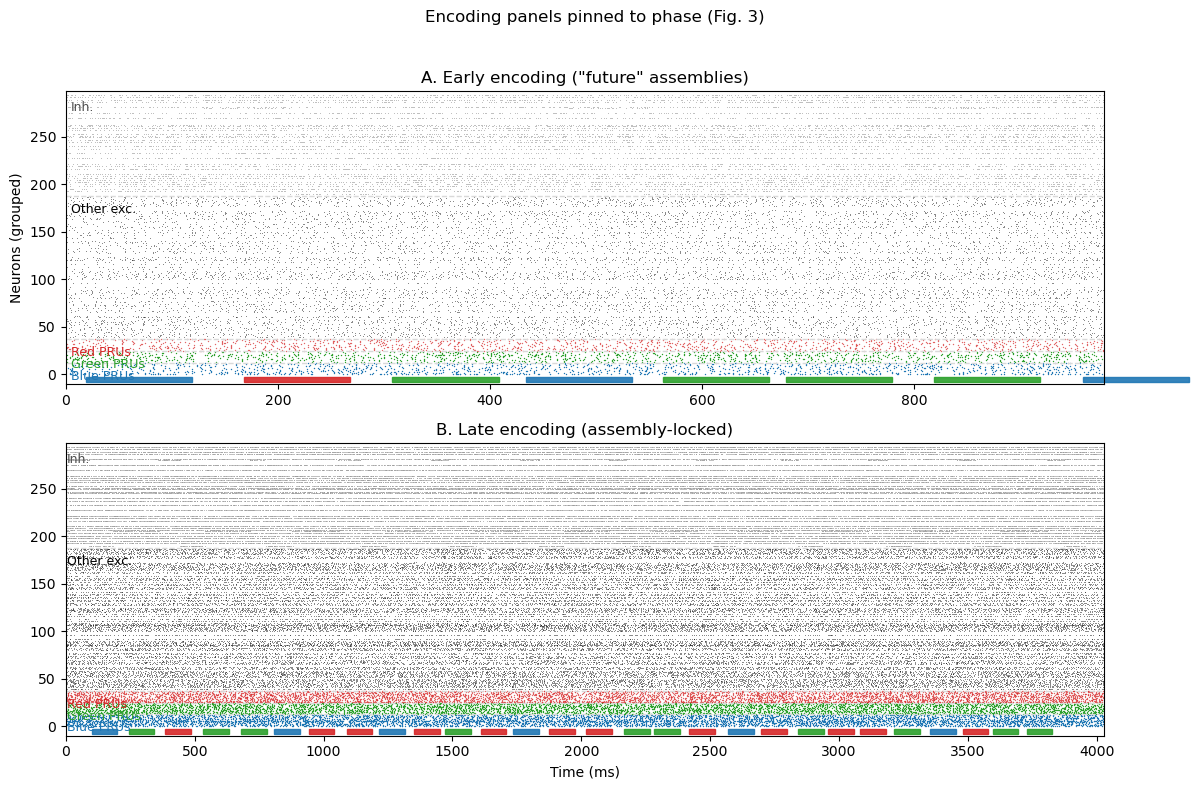

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from config import CFG
from analyze import detect_PRUs

def _encoding_bounds(schedule):
    """Return [t_enc_start, t_enc_end) in ms."""
    assert schedule and schedule[0]["kind"]=="noise"
    t = 0
    t_enc_start = schedule[0]["T_ms"]              # after initial noise
    # find first combined segment (association); encoding ends right before it
    t_enc_end = sum(s["T_ms"] for s in schedule)   # fallback
    acc = 0
    for seg in schedule:
        if seg["kind"] == "combined":
            t_enc_end = acc
            break
        acc += seg["T_ms"]
    return t_enc_start, t_enc_end

def _pattern_onsets_between(schedule, labels, t0, t1):
    """Dict label -> array of onsets (ms) with t0 <= onset < t1."""
    out = {lab: [] for lab in labels}
    t = 0
    for seg in schedule:
        if seg["kind"] == "pattern" and seg["label"] in labels and (t0 <= t < t1):
            out[seg["label"]].append(t)
        t += seg["T_ms"]
    for k in out: out[k] = np.array(out[k], dtype=int)
    return out

def _collect_rows(spike_trains, ids, t0, t1, offset):
    rows, cols = [], []
    for r, i in enumerate(ids):
        ts = spike_trains[i]
        if ts.size == 0: continue
        sel = ts[(ts >= t0) & (ts < t1)]
        if sel.size == 0: continue
        rows.extend([offset + r] * sel.size)
        cols.extend(sel - t0)
    return rows, cols

def plot_encoding_panels(out, first_n=6, last_n=6, pre_ms=100, post_ms=300,
                         max_other_E=150, max_I=108, title="Encoding (Fig. 3 style)"):
    E_spikes, I_spikes, sched = out["E_spike_times"], out["I_spike_times"], out["schedule"]
    labels = ["blue","green","red"]

    # 1) encoding window
    enc0, enc1 = _encoding_bounds(sched)

    # onsets within encoding
    enc_onsets = _pattern_onsets_between(sched, labels, enc0, enc1)

    # 2) detect assemblies *using all encoding onsets*
    res = detect_PRUs(E_spikes, enc_onsets, labels)
    blue_ids  = np.array(res["assemblies"]["blue"], dtype=int)
    green_ids = np.array(res["assemblies"]["green"], dtype=int)
    red_ids   = np.array(res["assemblies"]["red"], dtype=int)

    # plotting order (shared y across panels)
    E_all = np.arange(CFG.N_E, dtype=int)
    in_any = np.zeros(CFG.N_E, dtype=bool)
    in_any[blue_ids] = True; in_any[green_ids] = True; in_any[red_ids] = True
    other_E = E_all[~in_any]
    if other_E.size > max_other_E:
        other_E = np.random.default_rng(0).choice(other_E, size=max_other_E, replace=False)
    I_plot = np.arange(min(CFG.N_I, max_I), dtype=int)

    # panel A window: first_n encoding pattern onsets across all colors
    first_all = np.sort(np.concatenate([enc_onsets[k][:first_n] for k in labels if enc_onsets[k].size]))
    if first_all.size == 0:
        tA0, tA1 = enc0, min(enc0+1500, enc1)
    else:
        tA0 = max(enc0, int(first_all[0] - pre_ms))
        tA1 = min(enc1, int(first_all[min(len(first_all)-1, first_n-1)] + post_ms))

    # panel B window: last_n encoding pattern onsets across all colors
    last_all = np.sort(np.concatenate([enc_onsets[k][-last_n:] for k in labels if enc_onsets[k].size]))
    if last_all.size == 0:
        tB0, tB1 = max(enc0, enc1-1500), enc1
    else:
        tB0 = max(enc0, int(last_all[0] - pre_ms))
        tB1 = min(enc1, int(last_all[-1] + post_ms))

    def make_panel(ax, t0, t1):
        # rows per group (shared IDs/order with the other panel)
        rb, cb = _collect_rows(E_spikes, blue_ids,  t0, t1, 0)
        rg, cg = _collect_rows(E_spikes, green_ids, t0, t1, len(blue_ids))
        rr, cr = _collect_rows(E_spikes, red_ids,   t0, t1, len(blue_ids)+len(green_ids))
        off_E  = len(blue_ids) + len(green_ids) + len(red_ids)
        ro, co = _collect_rows(E_spikes, other_E,   t0, t1, off_E)
        off_I  = off_E + len(other_E)
        ri, ci = _collect_rows(I_spikes, I_plot,    t0, t1, off_I)

        ax.scatter(cb, rb, s=4, marker='.', color='tab:blue',  linewidths=0)
        ax.scatter(cg, rg, s=4, marker='.', color='tab:green', linewidths=0)
        if len(rr): ax.scatter(cr, rr, s=4, marker='.', color='tab:red', linewidths=0, alpha=0.7)
        ax.scatter(co, ro, s=2, marker='.', color='k',    linewidths=0, alpha=0.35)
        ax.scatter(ci, ri, s=2, marker='.', color='0.6',  linewidths=0, alpha=0.5)

        # separators + labels
        yb = len(blue_ids); yg = yb+len(green_ids); yr = yg+len(red_ids); ye = yr+len(other_E)
        for y in [yb-0.5, yg-0.5, yr-0.5, ye-0.5]:
            ax.hlines(y, 0, t1-t0, linestyles='dashed', colors='0.85', linewidth=1)
        ax.text(5, max(0,yb-8), "Blue PRUs",  color='tab:blue',  fontsize=9, va='top')
        ax.text(5, max(0,yg-8), "Green PRUs", color='tab:green', fontsize=9, va='top')
        if len(red_ids): ax.text(5, max(0,yr-8), "Red PRUs", color='tab:red', fontsize=9, va='top')
        ax.text(5, max(0,ye-8), "Other exc.", color='k', fontsize=9, va='top')
        ax.text(5, off_I + len(I_plot) - 8, "Inh.", color='0.3', fontsize=9, va='top')

        # pattern bars (100 ms)
        for lab, col in zip(["blue","green","red"], ['tab:blue','tab:green','tab:red']):
            for onset in enc_onsets[lab]:
                if t0 <= onset < t1:
                    ax.add_patch(Rectangle((onset - t0, -8), 100, 5, color=col, alpha=0.9, clip_on=False))

        ax.set_xlim(0, t1 - t0)
        ax.set_ylim(-10, off_I + len(I_plot) + 2)

    # plot two panels sharing y-axis structure
    fig, (axA, axB) = plt.subplots(2, 1, figsize=(12, 8), sharey=True)

    make_panel(axA, tA0, tA1); axA.set_title("A. Early encoding (\"future\" assemblies)"); axA.set_ylabel("Neurons (grouped)")
    make_panel(axB, tB0, tB1); axB.set_title("B. Late encoding (assembly-locked)");     axB.set_xlabel("Time (ms)")

    fig.suptitle(title, y=0.98)
    fig.tight_layout(rect=[0,0,1,0.96])
    plt.show()

plot_encoding_panels(out, first_n=6, last_n=6, title="Encoding panels pinned to phase (Fig. 3)")
